# Background

This analysis is inspired by ["Characteristics and Price Increases Among Sole-Source, Off-Patent Drugs in the United States, 2008 to 2018" ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7431990/?report=printable)

Alpern et al noted that of 300 sole-source, off-patent, off-exclusivity (OP-OE) drug products included in their study from January 1, 2008*, to December 31, 2018:
- The overall inflation-adjusted mean increase in drug prices was 8.8% per year. 
- Ninety-five drugs (31.7%) increased by 25% or more during any calendar year, and 66 drugs (22.0%) increased by 50% or more during any calendar year. 
- Price increases of at least 25% were more likely to occur among dermatologic drugs, a class known for price increases affecting off-patent drugs.
- Drugs in the antineoplastic and immunomodulatory class were more likely to sustain price hikes of at least 25% and 50%. This finding is noteworthy considering that all of the price increases among cancer drugs affected old drugs that have been on the market for at least the last 3 decades.

*Note: The original study only used the 2019 OPOE list as the basis for product selection; no comparison was done between OPOE years

// consider focusing on a specific pharmacological class
// drug through time - how was price moved based on historical data 
// is it a bad thing for a product to be on a list? discontinued products based on prescribing etc
// are any products related to previous epidemics?
// begin with product and follow the product through time... check historical data...consider products on this list with different 

# Research Questions

- Who are the producers of the products on the FDA's OP-OE list (v. 06-21)?
- When were drugs on the OP-OE list (v. 06-21) first approved?
- Based on the first OP-OE list in 2017, how many new manufacturers have entered the market in the US?

<i> 
 - Are any of these single source products available in other markets (e.g. Asia, Europe)? [need to hunt for datasets - European Medicines Agency? India's National Medicines Registry?]  
- What are the current prices for these products? [need to hunt for datasets - GoodRx?] </i>

# Datasets

### [List of Off-Patent, Off-Exclusivity Drugs without an Approved Generic](https://www.fda.gov/drugs/abbreviated-new-drug-application-anda/list-patent-exclusivity-drugs-without-approved-generic)

The FDA maintains a list of approved new drug application (NDA) drug products that are no longer protected by patents or exclusivities, and for which the FDA has not approved an abbreviated new drug application (ANDA) referencing that NDA product. The FDA updates this list every six months (in June and December) to improve transparency and encourage the development and submission of ANDAs in markets with little competition.

The list is separated into three sections:

- Part I identifies those drug products for which FDA could immediately accept an ANDA without prior discussion.
- Part II identifies drug products for which ANDA development or approval may raise potential legal, regulatory, or scientific issues that should be addressed with the Agency prior to considering submission of an ANDA.
- The Appendix identifies NDA drug products that were removed from Part I or Part II of the list because one or more ANDAs referencing such NDA drug products have been approved since the previous list publication.

### openFDA API - Drugs@FDA
Documentation here: https://open.fda.gov/apis/drug/

# Methodology - pseudocode

## Dataset Prep

### OP-OE (Pseudocode)
- Download 2017-2021 datasets
- Create a merged dataframe with all products an additional column to denote date of original list
- Check dataset for nulls, duplicates, strange values
- In a new data frame, extract all NDAs, drop duplicate values, and send to list
    - nda_list will be used to generate urls a la LastFM

### OP-OE (Cleaning Code)

In [126]:
# Import libraries
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import datetime

#### Read in FDA's OP-OE Lists

In [90]:
#June 2017 List Part I
opoe0617 = pd.read_excel('opoe_data/2017-06 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx')

In [91]:
opoe0617[opoe0617['Approved NDA'].str.contains(";")]

,Ingredient,Approved NDA
3,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021163; N021559
11,"AMINO ACIDS; MAGNESIUM CHLORIDE; POTASSIUM PHOSPHATE, DIBASIC; SODIUM CHLORIDE",N017673; N017789
16,ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE; RIBOFLAVIN; THIAMINE; TOCOPHEROL ACETATE; VITAMIN A; VITAMIN K,N021265; N021646
19,ASCORBIC ACID; BIOTIN; CYANOCOBALAMIN; DEXPANTHENOL; ERGOCALCIFEROL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A; VITAMIN E; VITAMIN K,N021625; N021643
21,ATROPINE SULFATE,N021146; N206289; N208151
25,BARIUM SULFATE,N208036; N208143; N208844
31,BUTENAFINE HYDROCHLORIDE,N020524; N021307
33,CALCIUM CHLORIDE; DEXTROSE; GLUTATHIONE DISULFIDE; MAGNESIUM CHLORIDE; POTASSIUM CHLORIDE; SODIUM BICARBONATE; SODIUM CHLORIDE; SODIUM PHOSPHATE,N018469; N020079
35,CALCIUM CHLORIDE; DEXTROSE; MAGNESIUM CHLORIDE; SODIUM CHLORIDE; SODIUM LACTATE,N017512; N018883; N020163; N020171; N020183
37,CALCIUM CHLORIDE; DEXTROSE; POTASSIUM CHLORIDE; SODIUM CHLORIDE,N018254; N020000


In [92]:
# split 'Approved NDA' based on ';' such that each NDA is its own record
opoe0617 = opoe0617.set_index(['Ingredient']).apply(lambda x: x.str.split(';').explode()).reset_index()

In [93]:
# add additional columns to match rest of opoe lists
opoe0617['Dosage Form'] = ''
opoe0617['Part'] = 'Part I'
opoe0617['pub_date'] = '2017-06'

In [94]:
opoe0617

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
0,ACETYLCHOLINE CHLORIDE,N020213,,Part I,2017-06
1,ACRIVASTINE; PSEUDOEPHEDRINE HYDROCHLORIDE,N019806,,Part I,2017-06
2,ALBENDAZOLE,N020666,,Part I,2017-06
3,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021163,,Part I,2017-06
4,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021559,,Part I,2017-06
...,...,...,...,...,...
217,TRIPTORELIN PAMOATE,N022437,,Part I,2017-06
218,TROMETHAMINE,N013025,,Part I,2017-06
219,TRYPAN BLUE,N021670,,Part I,2017-06
220,TRYPAN BLUE,N022278,,Part I,2017-06


In [95]:
#June 2017 List Part II
opoe0617p2 = pd.read_excel('opoe_data/2017-06 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx', sheet_name = 1)
# split 'Approved NDA' based on ';' such that each NDA is its own record
opoe0617p2 = opoe0617p2.set_index(['Ingredient']).apply(lambda x: x.str.split(';').explode()).reset_index()
# add additional columns to match rest of opoe lists
opoe0617p2['Dosage Form'] = ''
opoe0617p2['Part'] = 'Part II'
opoe0617p2['pub_date'] = '2017-06'

In [96]:
#Read in subsequent publications...
opoe1217 = pd.read_excel('opoe_data/2017-12 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx')
opoe1217['Part'] = 'Part I'
opoe1217['pub_date'] = '2017-12'

opoe1217p2 = pd.read_excel('opoe_data/2017-12 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx', sheet_name = 1)
opoe1217p2['Part'] = 'Part II'
opoe1217p2['pub_date'] = '2017-12'

In [97]:
opoe0618 = pd.read_excel('opoe_data/2018-06 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx')
opoe0618['Part'] = 'Part I'
opoe0618['pub_date'] = '2018-06'

opoe0618p2 = pd.read_excel('opoe_data/2018-06 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx', sheet_name = 1)
opoe0618p2['Part'] = 'Part II'
opoe0618p2['pub_date'] = '2018-06'

In [98]:
opoe1218 = pd.read_excel('opoe_data/2018-12 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx')
opoe1218['Approved NDA'] = opoe1218['Approved NDA'].astype('str')
opoe1218['Part'] = 'Part I'
opoe1218['pub_date'] = '2018-12'
#NEED TO ADD PADDING TO NDAs
opoe1218['Approved NDA'] = opoe1218['Approved NDA'].str.zfill(6)

opoe1218p2 = pd.read_excel('opoe_data/2018-12 List of Off Patent Off Exclusivity Drugs w no Approved Generic.xlsx', sheet_name = 1)
opoe1218p2['Approved NDA'] = opoe1218p2['Approved NDA'].astype('str')
opoe1218p2['Part'] = 'Part II'
opoe1218p2['pub_date'] = '2018-12'
#NEED TO ADD PADDING TO NDAs
opoe1218p2['Approved NDA'] = opoe1218p2['Approved NDA'].str.zfill(6)

In [99]:
opoe0619 = pd.read_excel('opoe_data/2019_06_opoe_list_for_posting.xlsx')
opoe0619['Approved NDA'] = opoe0619['Approved NDA'].astype('str')
opoe0619['Part'] = 'Part I'
opoe0619['pub_date'] = '2019-06'
#NEED TO ADD PADDING TO NDAs
opoe0619['Approved NDA'] = opoe0619['Approved NDA'].str.zfill(6)

opoe0619p2 = pd.read_excel('opoe_data/2019_06_opoe_list_for_posting.xlsx', sheet_name = 1)
opoe0619p2['Approved NDA'] = opoe0619p2['Approved NDA'].astype('str')
opoe0619p2['Part'] = 'Part II'
opoe0619p2['pub_date'] = '2019-06'
#NEED TO ADD PADDING TO NDAs
opoe0619p2['Approved NDA'] = opoe0619p2['Approved NDA'].str.zfill(6)

In [100]:
opoe1219 = pd.read_excel('opoe_data/final-201912-opoe-list-excel-posting.xlsx')
opoe1219['Approved NDA'] = opoe1219['Approved NDA'].astype('str')
opoe1219['Part'] = 'Part I'
opoe1219['pub_date'] = '2019-12'
#NEED TO ADD PADDING TO NDAs
opoe1219['Approved NDA'] = opoe1219['Approved NDA'].str.zfill(6)

opoe1219p2 = pd.read_excel('opoe_data/final-201912-opoe-list-excel-posting.xlsx', sheet_name = 1)
opoe1219p2['Approved NDA'] = opoe1219p2['Approved NDA'].astype('str')
opoe1219p2['Part'] = 'Part II'
opoe1219p2['pub_date'] = '2019-12'
#NEED TO ADD PADDING TO NDAs
opoe1219p2['Approved NDA'] = opoe1219p2['Approved NDA'].str.zfill(6)

In [101]:
opoe0620 = pd.read_excel('opoe_data/opoe_update_2020_06_12_for_posting.xlsx')
opoe0620['Part'] = 'Part I'
opoe0620['pub_date'] = '2020-06'

opoe0620p2 = pd.read_excel('opoe_data/opoe_update_2020_06_12_for_posting.xlsx', sheet_name = 1)
opoe0620p2['Part'] = 'Part II'
opoe0620p2['pub_date'] = '2020-06'

In [102]:
opoe1220 = pd.read_excel('opoe_data/opoe_update_for_posting_2020_12.xlsx')
opoe1220['Part'] = 'Part I'
opoe1220['pub_date'] = '2020-12'

opoe1220p2 = pd.read_excel('opoe_data/opoe_update_for_posting_2020_12.xlsx', sheet_name = 1)
opoe1220p2['Part'] = 'Part II'
opoe1220p2['pub_date'] = '2020-12'

In [104]:
#Latest Version: June 2021
opoe0621 = pd.read_excel('opoe_data/opoe_update_for_posting_2021_6.xlsx')
opoe0621['Part'] = 'Part I'
opoe0621['pub_date'] = '2021-06'

opoe0621p2 = pd.read_excel('opoe_data/opoe_update_for_posting_2021_6.xlsx', sheet_name = 1)
opoe0621p2['Part'] = 'Part II'
opoe0621p2['pub_date'] = '2021-06'

In [105]:
opoe0621.info()
# No null values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Ingredient    311 non-null    object
 1   Approved NDA  311 non-null    object
 2   Dosage Form   311 non-null    object
 3   Part          311 non-null    object
 4   pub_date      311 non-null    object
dtypes: object(5)
memory usage: 12.3+ KB


In [106]:
opoe0621.describe()

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
count,311,311,311,311,311
unique,245,308,38,1,1
top,SODIUM CHLORIDE,N016822,INJECTABLE,Part I,2021-06
freq,5,3,105,311,311


In [107]:
opoe0621.head(3)

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
0,ACETYLCHOLINE CHLORIDE,N020213,FOR SOLUTION,Part I,2021-06
1,ALENDRONATE SODIUM; CHOLECALCIFEROL,N021762,TABLET,Part I,2021-06
2,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021163,SOLUTION,Part I,2021-06


In [108]:
opoe0621[opoe0621.duplicated(subset=['Ingredient'])]
# 66 duplicate ingredients

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
5,AMINO ACIDS,N017766,INJECTABLE,Part I,2021-06
6,AMINO ACIDS,N018931,INJECTABLE,Part I,2021-06
7,AMINO ACIDS,N019398,INJECTABLE,Part I,2021-06
8,AMINO ACIDS,N020849,INJECTABLE,Part I,2021-06
26,ASCORBIC ACID; BIOTIN; CYANOCOBALAMIN; DEXPANTHENOL; ERGOCALCIFEROL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A; VITAMIN E; VITAMIN K,N021643,INJECTABLE,Part I,2021-06
...,...,...,...,...,...
293,TIPRANAVIR,N022292,SOLUTION,Part I,2021-06
296,TRETINOIN,N021108,CREAM,Part I,2021-06
299,TRIPTORELIN PAMOATE,N021288,INJECTABLE,Part I,2021-06
302,TRYPAN BLUE,N022278,SOLUTION,Part I,2021-06


In [109]:
pd.set_option('display.max_colwidth',500)

In [110]:
opoe0621[opoe0621.duplicated(subset=['Approved NDA'])]
# 3 duplicate NDAs...which is strange. Should be an even number

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
12,AMINO ACIDS; MAGNESIUM ACETATE; PHOSPHORIC ACID; POTASSIUM ACETATE; POTASSIUM CHLORIDE; SODIUM ACETATE,N016822,INJECTABLE,Part I,2021-06
13,AMINO ACIDS; MAGNESIUM ACETATE; PHOSPHORIC ACID; POTASSIUM CHLORIDE; SODIUM ACETATE; SODIUM CHLORIDE,N016822,INJECTABLE,Part I,2021-06
23,ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE; RIBOFLAVIN; THIAMINE; TOCOPHEROL HYDROCHLORIDE; VITAMIN A; VITAMIN K,N021265,INJECTABLE,Part I,2021-06


In searching the FDA website:
- 021265 is related to two types of product packaging for individual use and in bulk
- 016822 appears twice in the list because of multiple packages and strengths, as well as salts in the ingredient list 
    - FREAMINE III 3% W/ ELECTROLYTES = amino acid ending with sodium chloride
    - FREAMINE III 8.5%	AMINO ACIDS	= amino acid ending with sodium acetate

In [111]:
# Merge all OPOE Datasets together
dataframes = [opoe0617, opoe1217, opoe0618, opoe1218, opoe0619, opoe1219, opoe0620, opoe1220, opoe0621,opoe0617p2, opoe1217p2, opoe0618p2, opoe1218p2, opoe0619p2, opoe1219p2, opoe0620p2, opoe1220p2, opoe0621p2]
opoe_merge = pd.concat(dataframes).reset_index(drop = True)

In [112]:
opoe_merge

,Ingredient,Approved NDA,Dosage Form,Part,pub_date
0,ACETYLCHOLINE CHLORIDE,N020213,,Part I,2017-06
1,ACRIVASTINE; PSEUDOEPHEDRINE HYDROCHLORIDE,N019806,,Part I,2017-06
2,ALBENDAZOLE,N020666,,Part I,2017-06
3,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021163,,Part I,2017-06
4,ALPHA-TOCOPHEROL ACETATE; ASCORBIC ACID; BIOTIN; CHOLECALCIFEROL; CYANOCOBALAMIN; DEXPANTHENOL; FOLIC ACID; NIACINAMIDE; PYRIDOXINE HYDROCHLORIDE; RIBOFLAVIN 5'-PHOSPHATE SODIUM; THIAMINE HYDROCHLORIDE; VITAMIN A PALMITATE; VITAMIN K,N021559,,Part I,2017-06
...,...,...,...,...,...
4306,XENON XE-133,N017284,GAS,Part II,2021-06
4307,XENON XE-133,N018327,GAS,Part II,2021-06
4308,ZANAMIVIR,N021036,POWDER,Part II,2021-06
4309,ZINC ACETATE,N020458,CAPSULE,Part II,2021-06


In [118]:
#Convert 'pub_date' to datetime format
opoe_merge['pub_date'] = pd.to_datetime(opoe_merge['pub_date'], format = '%Y-%m')

In [121]:
#Strip "N" from NDA id
opoe_merge['Approved NDA'] = (opoe_merge['Approved NDA'].str[-6:])

In [122]:
opoe_merge.groupby(by = 'pub_date').count()

,Ingredient,Approved NDA,Dosage Form,Part
pub_date,,,,
2017-06-01,390,390,390,390
2017-12-01,538,538,538,538
2018-06-01,544,544,544,544
2018-12-01,523,523,523,523
2019-06-01,503,503,503,503
2019-12-01,484,484,484,484
2020-06-01,443,443,443,443
2020-12-01,442,442,442,442
2021-06-01,444,444,444,444


In [123]:
opoe_merge['Approved NDA'].value_counts()

016822    24
018956    17
021305    14
021265    13
017789    10
          ..
020231     1
018336     1
021624     1
006383     1
018449     1
Name: Approved NDA, Length: 781, dtype: int64

In [125]:
#send all NDAs to list
opoe_list = (opoe_merge['Approved NDA'].unique().tolist())
opoe_list

['020213',
 '019806',
 '020666',
 '021163',
 '021559',
 '018582',
 '020678',
 '020734',
 '016822',
 '017789',
 '019437',
 '017673',
 '050824',
 '021264',
 '016931',
 '022268',
 '021265',
 '021646',
 '018920',
 '008809',
 '021625',
 '021643',
 '011483',
 '021146',
 '206289',
 '208151',
 '017744',
 '019678',
 '018689',
 '208036',
 '208143',
 '208844',
 '020532',
 '050114',
 '020576',
 '021290',
 '020816',
 '020524',
 '021307',
 '021117',
 '018469',
 '020079',
 '021703',
 '017512',
 '018883',
 '020163',
 '020171',
 '020183',
 '020577',
 '018254',
 '020000',
 '016679',
 '017608',
 '019367',
 '019634',
 '019685',
 '018895',
 '016693',
 '017635',
 '018156',
 '018251',
 '018495',
 '020002',
 '016682',
 '017641',
 '018494',
 '018681',
 '018921',
 '019416',
 '019632',
 '050095',
 '017989',
 '010669',
 '012750',
 '022113',
 '018961',
 '019481',
 '021314',
 '017765',
 '018960',
 '050748',
 '020287',
 '020118',
 '204150',
 '204683',
 '205583',
 '017385',
 '017610',
 '019873',
 '017484',
 '019513',

### Drugs@FDA (Pseudocode)
- Loop through each URL endpoint (amending each request with the NDA numbers extracted from OP-OE in 'nda_list')
- For each NDA, collect the following information in a dataframe (: example)

"submission_type": "ORIG",  
"submission_number": "1",  
"submission_status": "AP",  
"submission_status_date": "20110208",  
"application_number": ["NDA050824"],  
"brand_name": ["OMECLAMOX-PAK"],  
"generic_name": ["OMEPRAZOLE, CLARITHROMYCIN, AMOXICILLIN"],  
"manufacturer_name": ["Cumberland Pharmaceuticals Inc."]

- Remove the first three characters of the application number
- Merge Drug@FDA data frame with OP-OE data frame on application number

### Drugs@FDA API Call

Open FDA offers documentation on its Drug API's endpoints that are: 
- Adverse Events
- Product Labeling
- NDC Directory
- Recall Enforcement Reports
- Drugs@FDA <- the endpoint containing product application information

Each Drugs@FDA entry consists of four major sections:
- Application data: The top level information which contains the details of the application.
- Product data: A list of all products included in the application with details on each.
- Submissions data: A list of all submissions associated with the application with details of each.
- An <b>openfda</b> section: An annotation with additional identifiers associate with the application number, <b>if available</b>

In [ ]:
#Need more information to check on current manufacturers [NDA Holders]; let's connect to the Drugs@FDA to find more information about these products

Example query from openFDA: https://api.fda.gov/drug/drugsfda.json?search=products.marketing_status:"Discontinued"&limit=5

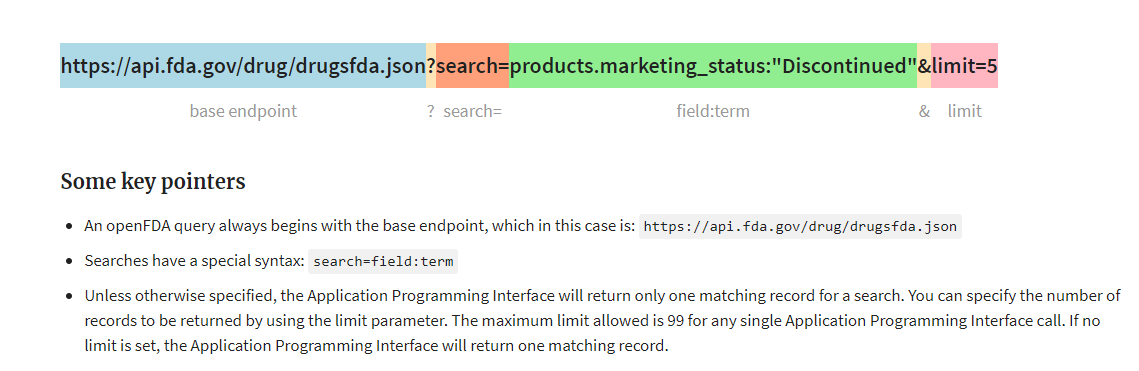

In [ ]:
# create a dataframe where every row is an application number (index)
# request based on application number
# merge API dataframe with opoe data frame

fda_r = requests.get('https://api.fda.gov/drug/drugsfda.json?limit=5')

In [ ]:
fda_r = fda_r.json()

In [ ]:
fda_r

I need to extract the following:
'results': [{'submissions': ...
   'application_number': 'ANDA077183',
   'sponsor_name': 'DR REDDYS LABS INC',
   'openfda': {'application_number': ['ANDA077183'],
   'brand_name': ['AMLODIPINE BESYLATE AND BENAZEPRIL HYDROCHLORIDE'],
   'generic_name': ['AMLODIPINE BESYLATE AND BENAZEPRIL HYDROCHLORIDE'],
   'manufacturer_name': ["Dr.Reddy's Laboratories Limited"],,,}

In [ ]:
fda_r.keys()
fda_results = fda_r['results']

In [ ]:
fda_submission = fda_results

In [ ]:
fda_submission.keys()

In [ ]:
open_fda = fda_submission['openfda']

In [ ]:
[print("col_name:",col_name, "\ndata:",data) for col_name, data in open_fda.items()]


In [ ]:
for r in fda_r['results']:
    try:
        print(r['openfda'])
    except:
        pass 

In [ ]:
for r in fda_r['results']:
    print(r['submissions'])
    for s in r['submissions']:
        print(s['open_fda'])

In [ ]:
fda_r['results'][0]['openfda']

In [ ]:
# create list out of the first data frame (application numbers)
# create string url (fda_url_base)
# append application 
fda_url_base = 'https://api.fda.gov/drug/drugsfda.json?search=application_number:'

nda_r = requests.get('https://api.fda.gov/drug/drugsfda.json?search=application_number:NDA020849')

In [ ]:
nda_r = nda_r.json()

In [ ]:
nda_r['results'][0].keys()

In [ ]:
nda_r['results'][0]['openfda'].keys()

In [ ]:
for items in nda_r['results'][0]['openfda']:
    print(items['brand_name'])
    print(items['generic_name'])
    print(items['manufacturer_name'])

In [ ]:
nda_r['results'][0]['openfda']['application_number']

In [ ]:
nda_r['results'][0]['openfda']['brand_name']

## Analysis - pseudocode
### Descriptive Stats

Who are the manufactuers of the products on the FDA's OP-OE list (v. 06-21)?
- group by manufacturers and count how many NDAs are associated with each

<blockquote> Bonus:
    
- Link with WHO ATC/DDD database...which therapeutic categories are most represented on the list? 
    
- Are the most frequently represented manufacturers concentrated in the most frequently represented therapeutic categories? 

- If there's a dataset on pharmaceutical mergers, it would be interesting to see if any of these companies were recently bought out...could be a signal for an impending price increase?
- Where are the manufactuers based? </blockquote>

When were drugs on the OP-OE list (v. 06-21) first approved?
- in the merged data frame, extract the first 4 characters of submission_status_date and send to new year_approved column
- create a new 'time since approval' column where today.year()-'year'
- in a new data frame, drop duplicates to 
    - find the average/median age of the product

### Analysis - Time

Have the number of products on the OP-OE lists increased from year to year?
- Calculate number of unique NDAs for each year of the OP-OE data

Based on the first OP-OE list in 2017, how many new manufacturers have entered the market in the US? (How many NDAs are dropped with each publication of the list?)
- List NDAs that do not appear on the list in each subsequent year
    -- get list of unique products in each year and send to list; check if elements of 2017_NDAs appear in the 2018_NDAs list etc (.unique().tolist() ... isin())
    
    
Quick analysis in excel shows something funky going on with the data...

| removal_date | count_removed | totalproducts_list | py_countremoved | discrepancies | change in list |
|--------------|---------------|--------------------|----------------------------|---------------|----------------|
| 2017-06      | 0             | 265                |                            |               |                |
| 2017-12      | 11            | 538                | 533                        |               | 273            |
| 2018-06      | 11            | 544                | 512                        | -5            | 6              |
| 2018-12      | 11            | 523                | 491                        | -32           | -21            |
| 2019-06      | 12            | 503                | 475                        | -32           | -20            |
| 2019-12      | 9             | 484                | 434                        | -28           | -19            |
| 2020-06      | 9             | 443                | 435                        | -50           | -41            |
| 2020-12      | 7             | 442                | 0                          | -8            | -1             |


How many new NDAs appear with every publication of the list?
- List new unique products which appear each year  
    -- get list of unique products in each year and send to list; check if 2018_NDAs appear in 2017_NDAs etc (.unique().tolist() ... isin())

<b> GRAPHIC: Stacked Bar Chart or Parallel Coordinates Chart </b> (a simpler version example below)  
   - OP-OE list years are encoded on on the access for the PC chart  
   - NDAs are encoded as values  
   - Grey lines indicate their continued existence on the list; red lines indicate when a new product has appeared on the list; green lines would that the product is eventually removed from the list
    
<b> Other graphics: </b>

   - histogram - distribution of number of drugs for a specific category (manufacturers)
   - small multiples - subplots (python)